# Experiment: L2 Horizontal flip
The goal of this experiment is to test the affect of horizontal flip data augmentation on the accuracy, precision, and recall. 

# Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
#from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.optimizers import SGD

# Preprocessing 

In [12]:
# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(selected_classes, normalize=True):
    dog_class_directory = os.getcwd()+'/dog_classes'
    
    total_sum = np.zeros(3)  # Assuming RGB images
    total_count = 0

    for class_name in selected_classes:
        class_dir = os.path.join(dog_class_directory, class_name)
        if not os.path.isdir(class_dir):
            print(f"Directory for class '{class_name}' not found, skipping.")
            continue
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.jpg', '.jpeg', '.png')):  # Adjust as needed for your image types
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                
                if normalize:
                    img_array /= 255.0  # Normalize to [0, 1]
                    
                total_sum += np.mean(img_array, axis=(0, 1))  # Mean over width, height for each channel
                total_count += 1

    if total_count == 0:
        print("No images found for the selected classes.")
        return None
    
    dataset_mean = total_sum / total_count
    return dataset_mean

In [13]:
# Zero-centering function
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Modify the dataset to apply zero-centering and normalization
def apply_zero_centering(dataset, dataset_mean, normalize=True):
    # Apply feature-wise centering and optional normalization
    def process_image(img, label):
        if normalize:
            img = img / 255.0  # Normalize to [0, 1] if normalize is True
        img = zero_centering(img, dataset_mean)  # Zero-center the image
        return img, label

    # Apply feature-wise centering and normalization by mapping the function
    zero_centered_dataset = dataset.map(
        process_image,
        num_parallel_calls=tf.data.AUTOTUNE  # Use parallel calls for efficiency
    )

    return zero_centered_dataset

# Model training

In [2]:
def get_classes(n: int):
    dog_class_directory = os.getcwd()+'/dog_classes'
    return os.listdir(dog_class_directory)[5:n+5]

# See the classes to train on
selected_classes = get_classes(8)

# 5 white coloured breeds, but dissimilar appearence 
# selected_classes = ['214-n000033-Bedlington_terrier', '211-n000058-Sealyham_terrier', '209-n000040-West_Highland_white_terrier', '225-n000073-Great_Pyrenees']

#breeds that look like a labrador
#selected_classes = ['207-n000045-redbone', '206-n000047-flat_coated_retriever', '215-n000075-Chesapeake_Bay_retriever', '202-n000028-curly_coated_retriever', '210-n000048-vizsla', '211-n000059-German_short_haired_pointer', '3580-n000122-Labrador_retriever', '5355-n000126-golden_retriever']
#selected_classes = ['207-n000045-redbone', '206-n000047-flat_coated_retriever', '215-n000075-Chesapeake_Bay_retriever', '202-n000028-curly_coated_retriever', '210-n000048-vizsla', '211-n000059-German_short_haired_pointer', '230-n000080-Rhodesian_ridgeback', '235-n000096-Weimaraner']

                    
                    
selected_classes = ['231-n000081-silky_terrier', '340-n000120-Yorkshire_terrier', '202-n000020-Australian_terrier', '203-n000016-Norwich_terrier','211-n000009-cairn', '203-n000021-Tibetan_terrier', '215-n000038-Lhasa', '211-n000052-Dandie_Dinmont', ]                    
                    
print(len(selected_classes))
print(selected_classes)

8
['231-n000081-silky_terrier', '340-n000120-Yorkshire_terrier', '202-n000020-Australian_terrier', '203-n000016-Norwich_terrier', '211-n000009-cairn', '203-n000021-Tibetan_terrier', '215-n000038-Lhasa', '211-n000052-Dandie_Dinmont']


In [25]:
# Print the number of elements (images) in each class
dog_class_directory = os.getcwd() + '/dog_classes'  # Define the directory path again

for c in selected_classes:
    class_directory = os.path.join(dog_class_directory, c)  # Full path to the class folder
    # List files in the class folder and count them
    num_images = len([f for f in os.listdir(class_directory) if os.path.isfile(os.path.join(class_directory, f))])
    print(f"Class '{c}' has {num_images} images.")


Class '231-n000081-silky_terrier' has 231 images.
Class '340-n000120-Yorkshire_terrier' has 341 images.
Class '202-n000020-Australian_terrier' has 202 images.
Class '203-n000016-Norwich_terrier' has 203 images.
Class '211-n000009-cairn' has 211 images.
Class '203-n000021-Tibetan_terrier' has 203 images.
Class '215-n000038-Lhasa' has 215 images.
Class '211-n000052-Dandie_Dinmont' has 211 images.


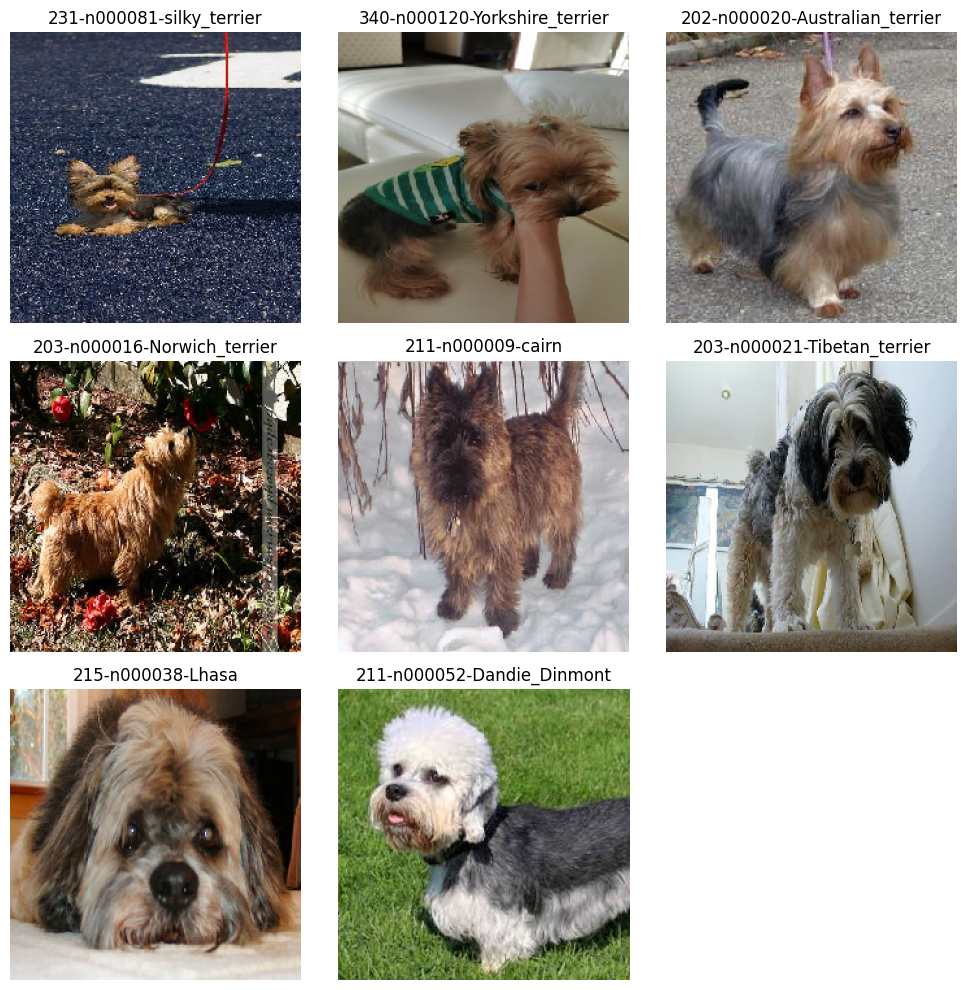

In [3]:
dog_class_directory = os.getcwd() + '/dog_classes'

# Set up the figure for displaying images
plt.figure(figsize=(10, 10))

# Loop over each class and display the first image
for i, class_name in enumerate(selected_classes):
    class_directory = os.path.join(dog_class_directory, class_name)
    image_files = os.listdir(class_directory)
    
    # Check if there are images in the class directory
    if image_files:
        first_image_path = os.path.join(class_directory, image_files[0])
        
        # Load and display the first image
        img = load_img(first_image_path, target_size=(224, 224))  # Resize for consistent display size
        ax = plt.subplot(3, 3, i + 1)  # Adjust grid as per number of classes
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


### Data augmentation

In [3]:
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import layers, Model

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal")  # Randomly flip images horizontally
])

# Load the MobileNet model without the top layers
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

# Define the augmented input by applying data augmentation to the input layer
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = data_augmentation(x, training=True)  # Apply augmentation here
x = conv_base(x, training=False)  # Pass augmented data through the MobileNet base

# Add custom top layers
x = GlobalAveragePooling2D()(x)  # Pooling layer
#x = Dense(1024, activation='relu')(x)  # Dense layer
x = Dense(1024, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01))(x)  # Dense layer with L2
#x = layers.Dropout(0.5)(x)  # Optional dropout
preds = Dense(len(selected_classes), activation='softmax')(x)  # Final output layer

# Create the final model
model = Model(inputs=inputs, outputs=preds)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,286,664 (16.35 MB)

 Trainable params: 4,264,776 (16.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [4]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:3]:
    print("off: ", layer)
    layer.trainable=False
for layer in model.layers[3:]:
    print("on: ", layer)
    layer.trainable=True
    

Total number of layers is 6
Number of pretrained base layers is 86
off:  <InputLayer name=input_layer_1, built=True>
off:  <Sequential name=sequential, built=True>
off:  <Functional name=mobilenet_1.00_224, built=True>
on:  <GlobalAveragePooling2D name=global_average_pooling2d, built=True>
on:  <Dense name=dense, built=True>
on:  <Dense name=dense_1, built=True>


In [5]:
dog_class_directory = os.getcwd()+'/dog_classes'
#dataset_mean = compute_dataset_mean(selected_classes, normalize=True)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

Found 1816 files belonging to 8 classes.
Using 1453 files for training.
Found 1816 files belonging to 8 classes.
Using 363 files for validation.


In [13]:
zero_norm_train_dataset = apply_zero_centering(train_dataset, dataset_mean, normalize=True)
zero_norm_val_dataset = apply_zero_centering(val_dataset, dataset_mean, normalize=True)

In [8]:
# Define the custom Cyclical Learning Rate class
class CyclicalLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, max_lr, step_size):
        super(CyclicalLearningRate, self).__init__()
        self.base_lr = base_lr  # Lower bound of the learning rate
        self.max_lr = max_lr    # Upper bound of the learning rate
        self.step_size = step_size  # Number of steps per half cycle

    def __call__(self, step):
        cycle = tf.floor(1 + step / (2 * self.step_size))
        x = tf.abs(step / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * tf.maximum(0., (1 - x))
        return lr

In [10]:
# Define base and max learning rates, and step size for the cyclical schedule
base_lr = 0.005
max_lr = 0.015
batch_size = 32
train_dataset_size = 1453
steps_per_epoch = 182
step_size = steps_per_epoch * 4  # Number of steps for one half cycle

print(steps_per_epoch)
print(step_size)

# Create the cyclical learning rate schedule
clr_schedule = CyclicalLearningRate(base_lr, max_lr, step_size)


# Use this schedule with an optimizer (e.g., Adam)
#optimizer = tf.keras.optimizers.SGD(learning_rate=clr_schedule)
sgd_optimizer = optimizers.SGD(learning_rate=clr_schedule, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=50)

182
728
Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.8200 - loss: 9.2553 - val_accuracy: 0.7466 - val_loss: 6.9269
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.8507 - loss: 5.9531 - val_accuracy: 0.7383 - val_loss: 4.1546
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.8246 - loss: 3.4923 - val_accuracy: 0.6997 - val_loss: 2.5946
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7770 - loss: 2.2057 - val_accuracy: 0.6474 - val_loss: 2.1787
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.7846 - loss: 1.5038 - val_accuracy: 0.7493 - val_loss: 1.5160
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7986 - loss: 1.1938 - val_accuracy: 0.6832 - val_loss: 1.4202
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.8577 - loss: 0.9091 - val_accuracy: 0.7934 - val_loss: 1.0103
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.8744 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


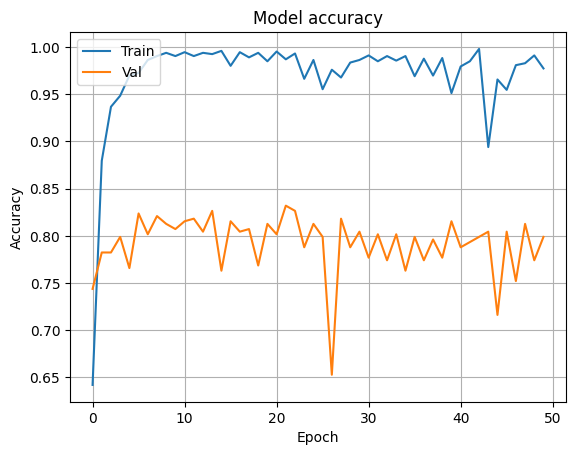

In [10]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### We are now ready to start training the model using


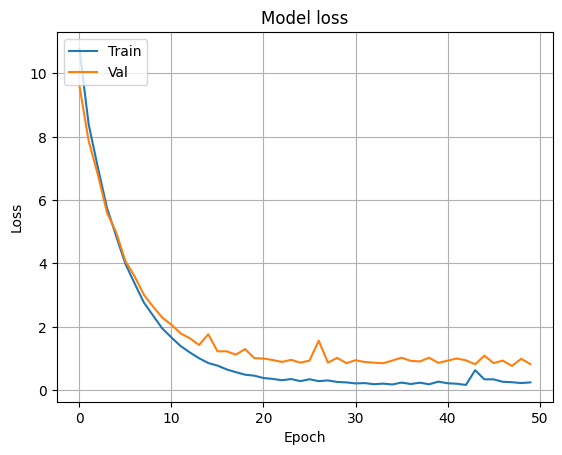

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [35]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(val_dataset, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.8034 - loss: 1.4882
test loss, test acc: [1.4748882055282593, 0.8292011022567749]


In [37]:
x_test_list = []
y_test_list = []

# Iterate over each (x, y) in the dataset, taking only y (labels)
for img, labels in val_dataset:
    x_test_list.append(img.numpy())
    y_test_list.append(labels.numpy())  # Convert labels to NumPy array and add to list
    
x_test_array = np.vstack(x_test_list) 
y_test_array = np.vstack(y_test_list) 

2024-11-25 10:02:11.379106: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
# Generate predictions directly on the dataset
predictions = model.predict(x_test_array, verbose=False)
print('predictions shape:', predictions.shape)
print(predictions)

predictions shape: (363, 8)
[[1.10550784e-04 2.11504994e-05 6.07742368e-06 ... 7.38265887e-02
  9.24416125e-01 5.84441179e-04]
 [5.30197501e-01 4.47934330e-01 1.42378884e-03 ... 1.43941288e-04
  3.79506120e-04 1.23163196e-03]
 [5.55463124e-08 3.56427687e-09 1.25158834e-07 ... 2.24072068e-07
  1.31714944e-06 9.99998331e-01]
 ...
 [6.00576459e-04 1.00029496e-07 8.27636256e-07 ... 2.24447576e-03
  1.02038364e-04 8.78943101e-05]
 [5.34946248e-02 3.18859331e-02 6.90556408e-06 ... 8.72289896e-01
  1.33709777e-02 2.87597813e-02]
 [1.07192454e-06 7.95413143e-05 1.43717200e-01 ... 2.51985784e-06
  6.24240192e-06 1.05126092e-04]]


In [39]:
y_test_class = np.argmax(y_test_array, axis=1)
predictions_class = np.argmax(predictions,axis=1)
print('predictions.shape:',predictions.shape)
print('predictions_class.shape:',predictions_class.shape)

predictions.shape: (363, 8)
predictions_class.shape: (363,)


In [40]:
print('predictions_class[:20]',predictions_class[:20])
print('y_test_class[:20]     ',y_test_class[:20])

predictions_class[:20] [6 0 7 2 0 6 0 0 5 5 3 5 6 7 2 1 0 0 2 2]
y_test_class[:20]      [6 3 7 2 2 6 2 0 5 5 3 5 6 7 2 1 0 0 2 2]


In [41]:
import numpy as np

# Use the get_accuracy function
def get_accuracy(predictions_class, y_test):
    # Convert one-hot encoded y_test to class indices
    y_test_class = np.argmax(y_test, axis=1)
    # Calculate number of correct predictions
    num_correct = np.sum(predictions_class == y_test_class)
    # Calculate accuracy
    accuracy = num_correct / len(y_test_class)
    return accuracy

# Assuming predictions_class contains predicted class indices
accuracy = get_accuracy(predictions_class, y_test_array)
print('accuracy:', accuracy)

accuracy: 0.8292011019283747


Confusion matrix, without normalization
Normalized confusion matrix


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

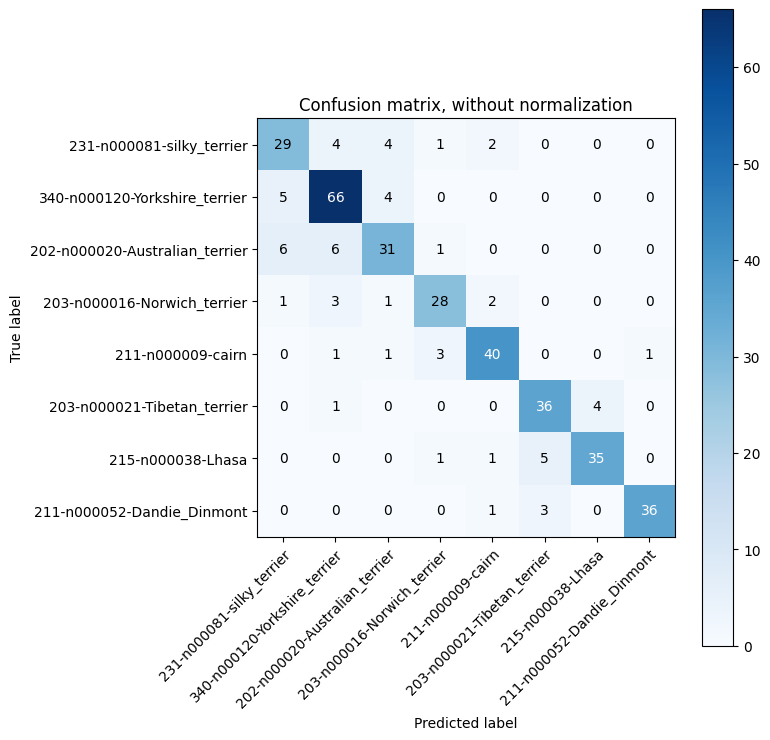

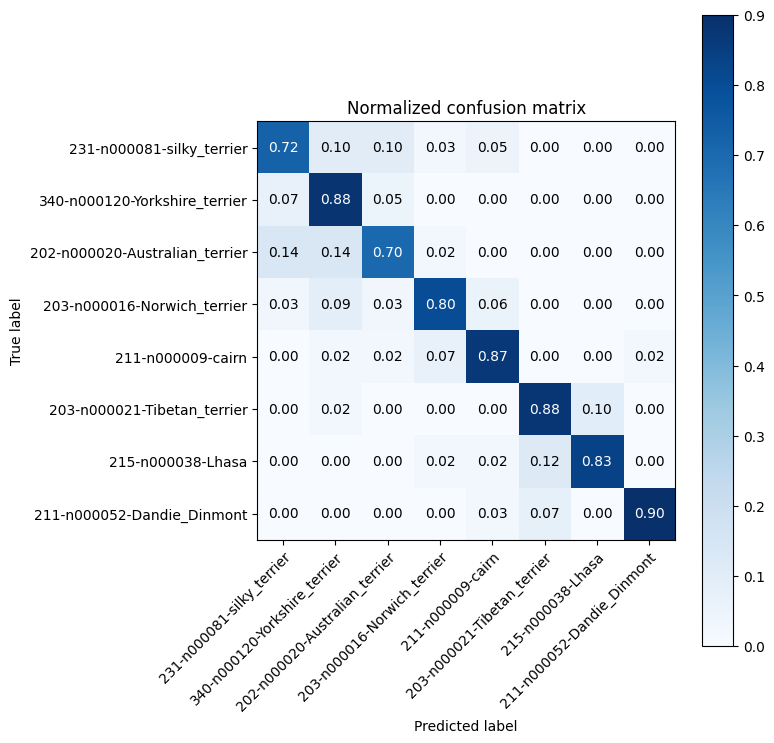

In [43]:
# From:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(8,8))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
labels = selected_classes
N = predictions_class.shape[0]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_class[:N], predictions_class, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_class[:N], predictions_class, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [44]:
import numpy as np

def get_top_k_accuracy_per_class(predictions, y_test, k):
    """
    Calculate the top-k accuracy for each class in the dataset and return as an array.

    Args:
        predictions (np.ndarray): Array of prediction probabilities, shape (num_samples, num_classes).
        y_test (np.ndarray): Array of true class indices, shape (num_samples,).
        k (int): Number of top predictions to consider.

    Returns:
        np.ndarray: An array where each row contains [class, top-k accuracy].
    """
    # Convert predictions to top-k predicted class indices
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]

    # Get the unique classes in y_test
    unique_classes = np.unique(y_test)

    # Initialize a list to collect results
    results = []

    # Iterate through each class and calculate top-k accuracy
    for cls in unique_classes:
        # Get indices of samples belonging to the current class
        cls_indices = np.where(y_test == cls)[0]
        
        # Filter top-k predictions and true labels for the current class
        cls_top_k_predictions = top_k_predictions[cls_indices]
        cls_true_labels = y_test[cls_indices]

        # Calculate top-k accuracy for the current class
        matches = [cls_true_labels[i] in cls_top_k_predictions[i] for i in range(len(cls_true_labels))]
        cls_accuracy = np.sum(matches) / len(cls_true_labels) if len(cls_true_labels) > 0 else 0

        # Append the class and its accuracy as a row
        results.append(cls_accuracy)

    # Convert the results to a numpy array
    return np.array(results)


In [45]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import top_k_accuracy_score
import pandas as pd

labels = selected_classes
recalls = recall_score(y_test_class, predictions_class, average=None)
precisions = precision_score(y_test_class, predictions_class, average=None)
top_3 = get_top_k_accuracy_per_class(predictions, y_test_class, 3)

# Create a DataFrame
data = {
    "Class Label": labels,
    "Precision": precisions,
    "Recall": recalls,
    "Top-3 accuracy": top_3
}
table = pd.DataFrame(data)

styled_table = table.style.set_table_styles(
    [
        {"selector": "thead", "props": [("background-color", "#4CAF50"), ("color", "white")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f2f2f2")]},
        {"selector": "tbody tr:hover", "props": [("background-color", "#ddd")]},
    ]
).set_properties(**{'text-align': 'center'})

print("Top 3 accuracy among all classes: ", top_k_accuracy_score(y_test_class, predictions, k=3))
styled_table  # Will display nicely in a Jupyter Notebook

Top 3 accuracy among all classes:  0.9696969696969697


,Class Label,Precision,Recall,Top-3 accuracy
0,231-n000081-silky_terrier,0.707317,0.725000,0.925000
1,340-n000120-Yorkshire_terrier,0.814815,0.880000,0.986667
2,202-n000020-Australian_terrier,0.756098,0.704545,0.977273
3,203-n000016-Norwich_terrier,0.823529,0.800000,0.942857
4,211-n000009-cairn,0.869565,0.869565,0.956522
5,203-n000021-Tibetan_terrier,0.818182,0.878049,0.975610
6,215-n000038-Lhasa,0.897436,0.833333,0.976190
7,211-n000052-Dandie_Dinmont,0.972973,0.900000,1.000000
